In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics as skm
from sklearn import svm
from sklearn.model_selection import train_test_split

# 1. Data Processing

The data in this assignment comes from the UC Irvine Machine Learning library.

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)

The data here doesn't have column names. They have to be added manually. The list of names comes from [here](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names).

In [3]:
cols = [
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education_num',
    'marital_status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital_gain',
    'capital_loss',
    'hours_per_week',
    'native_country',
    'salary'
]

df.columns = cols

Check the shape of the dataframe and print out a few rows to confirm everything looks good.

In [4]:
df.shape

(32561, 15)

In [5]:
# Unnecessary column
df.drop(columns='fnlwgt', inplace=True)

# Revalue the target variable
df.salary.replace({'<=50K':0, '>50K':1}, inplace=True)

In [6]:
df.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
X = df.drop(columns='salary')
y = df.salary

In [8]:
print(X.shape)
print(y.shape)

(32561, 13)
(32561,)


In [9]:
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=123)

print(X_train.shape)
print(X_test.shape)

(22792, 107)
(9769, 107)


# 2. Random Forest Classifier - Base Model:

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

y_test_rf_pred  = rf.predict(X_test)
y_test_rf_proba = rf.predict_proba(X_test)

print("\nTest Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_rf_pred))
print("\nTest Classification Report")
print(skm.classification_report(y_test, y_test_rf_pred))
print("\nTest ROC AUC")
print(skm.roc_auc_score(y_test, y_test_rf_proba[:,1]))


Test Confusion Matrix
[[6837  571]
 [ 967 1394]]

Test Classification Report
             precision    recall  f1-score   support

          0       0.88      0.92      0.90      7408
          1       0.71      0.59      0.64      2361

avg / total       0.84      0.84      0.84      9769


Test ROC AUC
0.8720583103034095


Text(0,0.5,'Feature Importance')

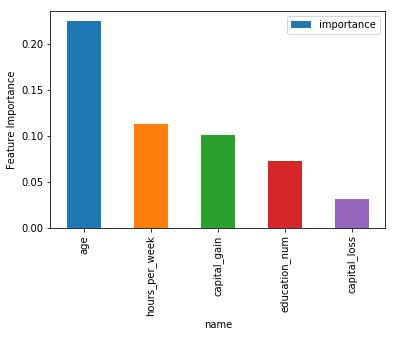

In [13]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': rf.feature_importances_}).head(5)
fi.sort_values('importance', ascending=False, inplace=True)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

## Overfitting 

Is there overfitting in this model? Random Forest is prone to overfitting. If the train accuracy and ROC AUC score are much higher than the test scores it is an indicator of overfitting.

In [14]:
y_train_rf_pred  = rf.predict(X_train)
y_train_rf_proba = rf.predict_proba(X_train)

print("Train Score:", round(rf.score(X_train, y_train), 2))
print("\nTrain Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_rf_pred))
print("\nTrain Classification Report")
print(skm.classification_report(y_train, y_train_rf_pred))
print("\nTrain ROC AUC")
print(skm.roc_auc_score(y_train, y_train_rf_proba[:,1]))
print("")

Train Score: 0.97

Train Confusion Matrix
[[17104   208]
 [  505  4975]]

Train Classification Report
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     17312
          1       0.96      0.91      0.93      5480

avg / total       0.97      0.97      0.97     22792


Train ROC AUC
0.9957291659639488



The RandomForest train score is much much higher than the test score. There is definite overfitting happening in the RandomForest classifier.

# 3. AdaBoost Classifier - GridSearch

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [16]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2,0.4,0.6,0.8,1, 1.2],
    'random_state' : [123]
}

abc = AdaBoostClassifier()

grid_search_abc = GridSearchCV(abc, parameters, cv=5, scoring='roc_auc',refit=True, n_jobs=-1, verbose=1)

grid_search_abc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [17]:
abc_best = grid_search_abc.best_estimator_

y_test_abc_pred  = abc_best.predict(X_test)
y_test_abc_proba = abc_best.predict_proba(X_test)

print("\nAdaBoost Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_abc_pred))
print("\nAdaBoost Test Classification Report")
print(skm.classification_report(y_test, y_test_abc_pred))
print("\nAdaBoost Test ROC AUC")
print(skm.roc_auc_score(y_test, y_test_abc_proba[:,1]))
print("")


AdaBoost Test Confusion Matrix
[[6988  420]
 [ 867 1494]]

AdaBoost Test Classification Report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7408
          1       0.78      0.63      0.70      2361

avg / total       0.86      0.87      0.86      9769


AdaBoost Test ROC AUC
0.9266556960068353



Text(0,0.5,'Feature Importance')

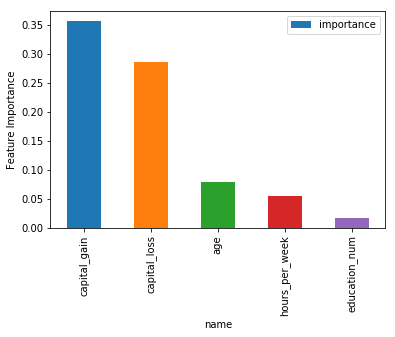

In [18]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': abc_best.feature_importances_}).head(5)
fi.sort_values('importance', ascending=False, inplace=True)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

In [19]:
y_train_abc_pred  = abc_best.predict(X_train)
y_train_abc_proba = abc_best.predict_proba(X_train)

In [20]:
print("\nAdaBoost Test Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_abc_pred))
print("\nAdaBoost Test Classification Report")
print(skm.classification_report(y_train, y_train_abc_pred))
print("\nAdaBoost Test ROC AUC")
print(skm.roc_auc_score(y_train, y_train_abc_proba[:,1]))
print("")


AdaBoost Test Confusion Matrix
[[16301  1011]
 [ 1895  3585]]

AdaBoost Test Classification Report
             precision    recall  f1-score   support

          0       0.90      0.94      0.92     17312
          1       0.78      0.65      0.71      5480

avg / total       0.87      0.87      0.87     22792


AdaBoost Test ROC AUC
0.9304835861290257



# 4. Gradient Boosting Classifier - GridSearch

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

In [22]:
parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.2,0.6,1.0],
    'max_depth': [1,2],
    'random_state' : [123]
}

gbc = GradientBoostingClassifier()

grid_search_gbc = GridSearchCV(gbc, parameters, cv=5, scoring='roc_auc',refit=True, n_jobs=-1, verbose=1)

grid_search_gbc.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 76.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [100, 200, 300, 400], 'learning_rate': [0.2, 0.6, 1.0], 'max_depth': [1, 2], 'random_state': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [23]:
gbc_best = grid_search_gbc.best_estimator_

In [24]:
y_test_gbc_pred  = gbc_best.predict(X_test)
y_test_gbc_proba = gbc_best.predict_proba(X_test)

In [25]:
print("\nAdaBoost Test Confusion Matrix")
print(skm.confusion_matrix(y_test, y_test_gbc_pred))
print("\nAdaBoost Test Classification Report")
print(skm.classification_report(y_test, y_test_gbc_pred))
print("\nAdaBoost Test ROC AUC")
print(skm.roc_auc_score(y_test, y_test_gbc_proba[:,1]))
print("")


AdaBoost Test Confusion Matrix
[[7000  408]
 [ 848 1513]]

AdaBoost Test Classification Report
             precision    recall  f1-score   support

          0       0.89      0.94      0.92      7408
          1       0.79      0.64      0.71      2361

avg / total       0.87      0.87      0.87      9769


AdaBoost Test ROC AUC
0.9279343770668613



Text(0,0.5,'Feature Importance')

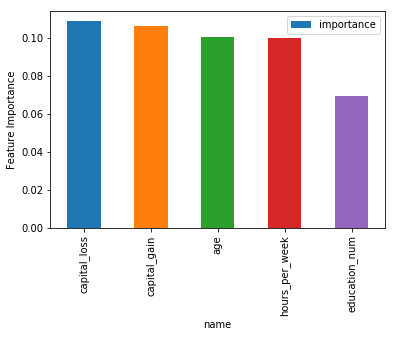

In [26]:
fi = pd.DataFrame({'name': X_test.columns, 'importance': gbc_best.feature_importances_}).head(5)
fi.sort_values('importance', ascending=False, inplace=True)
ax = fi.plot.bar(x='name', y='importance')
ax.set_ylabel('Feature Importance')

In [27]:
y_train_gbc_pred  = gbc_best.predict(X_train)
y_train_gbc_proba = gbc_best.predict_proba(X_train)

print("\nGradient Boost Test Confusion Matrix")
print(skm.confusion_matrix(y_train, y_train_gbc_pred))
print("\nnGradient Boost Test Classification Report")
print(skm.classification_report(y_train, y_train_gbc_pred))
print("\nnGradient Boost Test ROC AUC")
print(skm.roc_auc_score(y_train, y_train_gbc_proba[:,1]))
print("")


AdaBoost Test Confusion Matrix
[[16413   899]
 [ 1820  3660]]

AdaBoost Test Classification Report
             precision    recall  f1-score   support

          0       0.90      0.95      0.92     17312
          1       0.80      0.67      0.73      5480

avg / total       0.88      0.88      0.88     22792


AdaBoost Test ROC AUC
0.937715874900495



# Conceptual Problems: 

5) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.

6) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.

7) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?

8) In Part (e) of Steps 2-4 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).

9) From the models run in steps 2-4, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.

10) For your best performing model, plot out an ROC curve. Feel free to use sklearn, matplotlib or any other method in python.